**1) Data Description**  
**Introduction:** This project uses data from a Minecraft research server hosted by UBC’s PLAI group to understand player engagement and subscription behaviour. Two datasets are provided:

**players.csv:** This file contains 7 variables with demographic and account information for 196 players.  
**Variables in players.csv:**  
1) experience: This is a character variable, it specifies the players specific experience level. It is categorized into Veteran, Pro, Regular, Amateur, and Beginner.  
2) subscribe: This is a logical variable, it specifies whether the player is subcribed or not. It is categorized into TRUE or FALSE.  
3) hashedEmail: This is a character variable, it contains the players email in a hashed format.  
4) played_hours: This is a numerical variable (dbl). It contains the total number of gameplay hours per player.     
5) name: This is a character variable, it contains the players chosen name for the game.  
6) gender: This is a character variable, it contains the players specified gender.  
7) Age: This is a numerical variable (dbl). It contains the players age.
   
**Errors in players.csv**  
Some players lack Age values, raising concerns about data completeness and potential bias in analyses or predictions involving age. 

**sessions.csv** This file has 5 variables and records 1535 gameplay sessions for individual players.
**Variables in sessions.csv**  
1) hashedEmail: This is a character variable, it contains the players email in a hashed format. 
2) start_time: This is a character variable, it contains the gameplay session start time in the DD/MM/YYYY and HH:MM format.  
3) end_time: This is a character variable, it contains the gameplay session end time in the DD/MM/YYYY and HH:MM format.
4) original_start_time: This is a numerical variable (dbl). It contains the UNIX timestamp corresponding to the session start time.  
5) original_end_time: This is a numerical variable (dbl). It contains the UNIX timestamp corresponding to the session end time.

**Errors in sessions.csv**  
This dataset contains missing values in the end_time and original_end_time columns, and the time data are stored in two different formats (human-readable strings and UNIX timestamps), which will need to be cleaned and transformed before calculating useful information such as session duration.  

**2. Question:**   
**Broad Question:** What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?  
**Specific Question:** Can player demographics and gameplay behavior predict whether a player is subscribed to the game newsletter?  
I will merge the datasets by hashedEmail. I will also create visualizations to explore patterns and inform the KNN model.

**3. Exploratory Data Analysis and Visualization**

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [23]:
players_url <- "https://raw.githubusercontent.com/gavind1111/DSCI-100-Project-Planning-Stage-Gavin/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/gavind1111/DSCI-100-Project-Planning-Stage-Gavin/refs/heads/main/sessions.csv"
players_data <- read_csv(players_url) #Reading the players.csv file
sessions_data <- read_csv(sessions_url) #Reading the sessions.csv file

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [30]:
#Some minimal data wrangling to make the data ready for visualization and analysis
sessions_selected <- sessions_data |> 
    select(hashedEmail, start_time, end_time) |> # Keeping only the variables needed for analysis
    mutate(start_time = dmy_hm(start_time), #Convert start time to datetime format
           end_time = dmy_hm(end_time), #Convert end time to datetime format
           session_duration = as.numeric(end_time - start_time)) |> #Make a new column with the session duration
    group_by(hashedEmail) |> # Group by player so we can summarize behaviour per user
    summarize(average_session_duration = mean(session_duration, na.rm = TRUE), total_sessions = n()) #Summarizing the sessions file into the average time played per player, and number of sessions per player

combined_data <- merge(players_data, sessions_selected, by = "hashedEmail") #Combining the two datasets together using hashedEmail 

In [29]:
#The mean value for each quantitative variable in the players.csv data set
players_means <- players_data |>
    select(where(is.numeric)) |> # keep only numeric variables
    summarize(across(everything(), mean, na.rm = TRUE))|> #Calculating the mean values 
    pivot_longer(cols = everything(), names_to = "Variable", values_to = "Mean_Value") #Put the mean values into a table
players_means

Variable,Mean_Value
<chr>,<dbl>
played_hours,5.845918
Age,21.139175


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


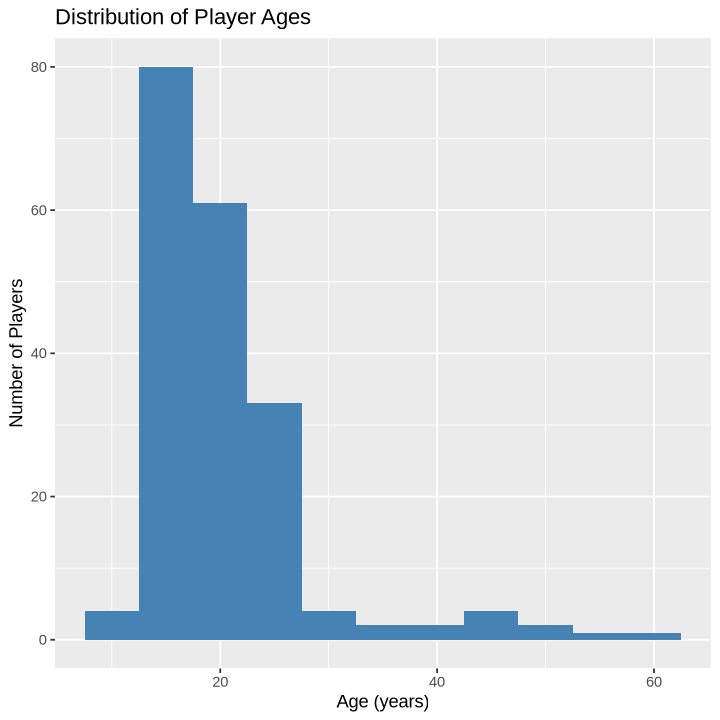

In [37]:
# Histogram showing the distribution of player ages
# Helps visualize the age range and most common age groups among all players
options(repr.plot.width = 6, repr.plot.height = 6) 
age_plot <- players_data |>
    ggplot(aes(x = Age)) +
    geom_histogram(binwidth = 5, fill = "SteelBlue") +
    labs(title = "Distribution of Player Ages", x = "Age (years)", y = "Number of Players")
age_plot

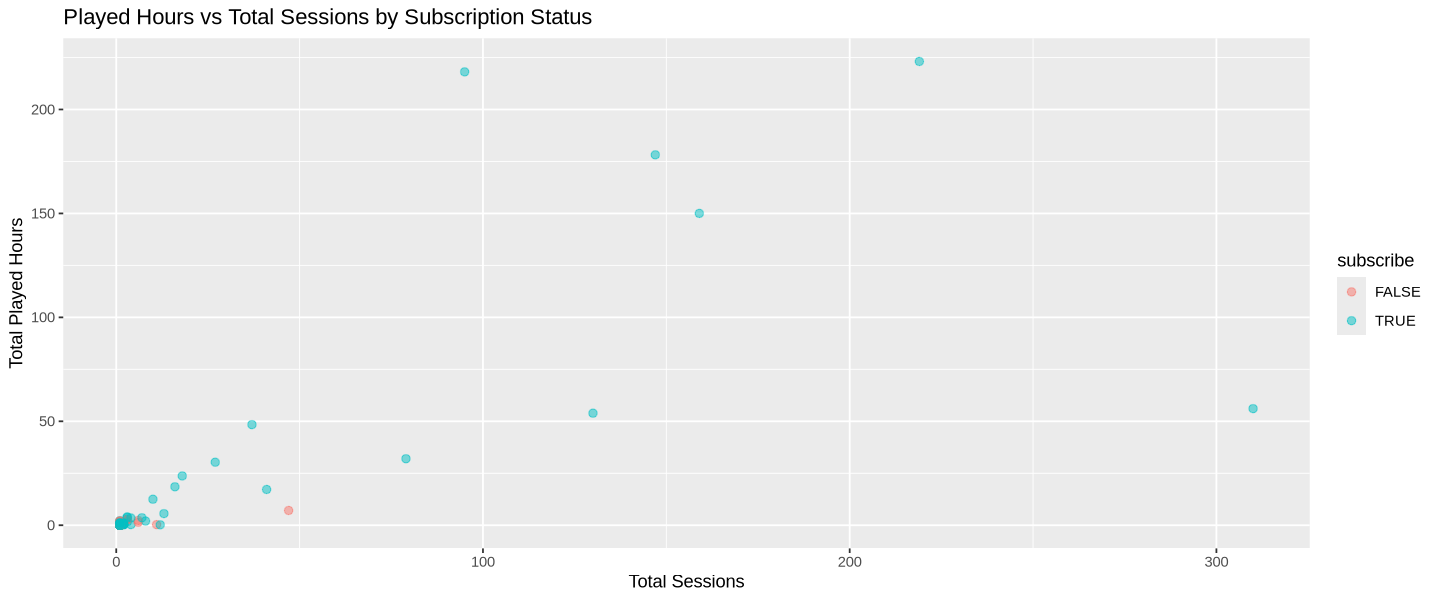

In [39]:
# Scatterplot showing relationship between total sessions and total played hours
# Highlights that players with more sessions tend to accumulate more played hours
options(repr.plot.width = 12, repr.plot.height = 5) 
sessions_vs_hours_plot <- combined_data |>
    ggplot(aes(x = total_sessions, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.5, size = 2) +
    labs(title = "Played Hours vs Total Sessions by Subscription Status", x = "Total Sessions",y = "Total Played Hours")
sessions_vs_hours_plot

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 14 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


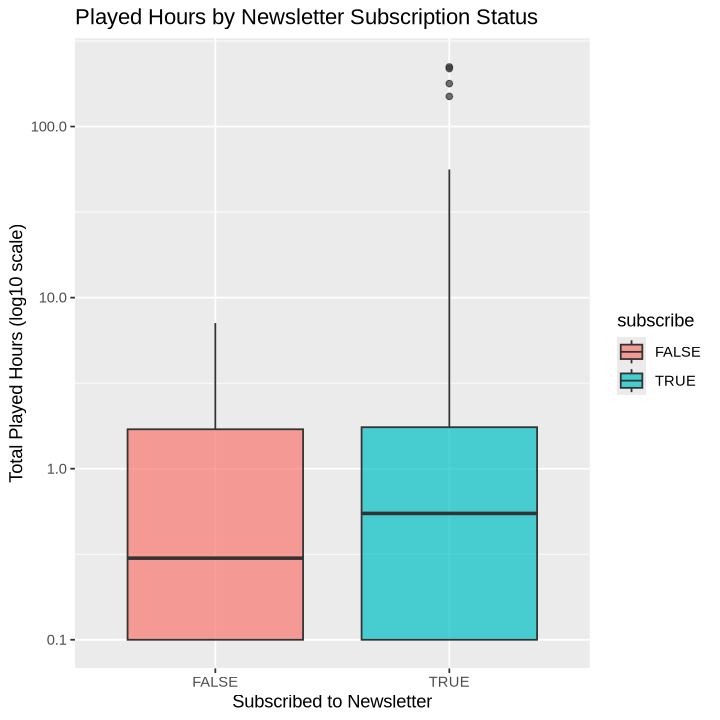

In [40]:
# Boxplot to compare total played hours between subscribed and non-subscribed players
# Shows that subscribed players tend to have higher playtime overall
options(repr.plot.width = 6, repr.plot.height = 6) 
hours_vs_subscribed_plot <- combined_data |>
    ggplot(aes(x = subscribe, y = played_hours, fill = subscribe)) +
    geom_boxplot(alpha = 0.7) +
    scale_y_log10() +
    labs(x = "Subscribed to Newsletter", y = "Total Played Hours (log10 scale)", title = "Played Hours by Newsletter Subscription Status")
hours_vs_subscribed_plot

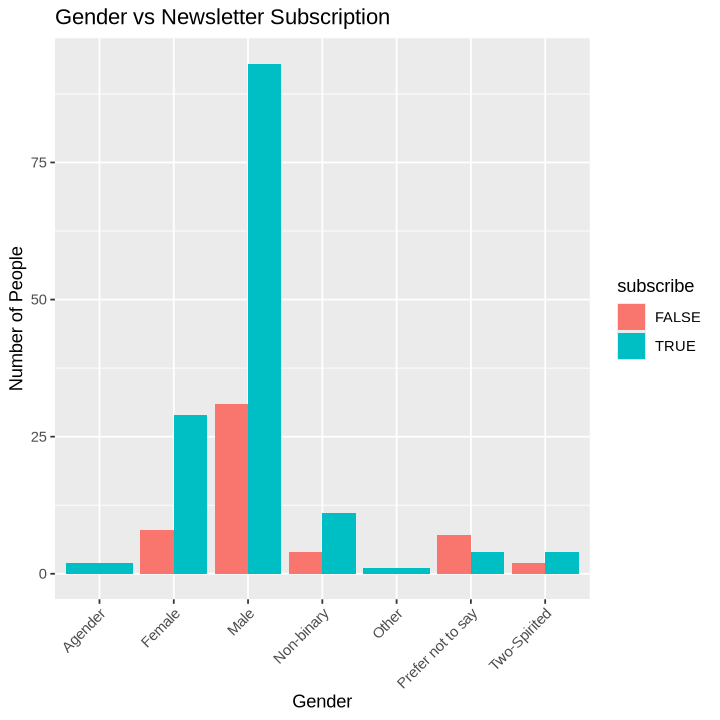

In [44]:
# Bar plot showing the number of players by gender, split by subscription status
# Lets us compare how many subscribed vs. not subscribed within each gender group
options(repr.plot.width = 6, repr.plot.height = 6) 
gender_vs_subscribed_barplot <- players_data |>
    ggplot(aes(x = gender, fill = subscribe)) +
    geom_bar(position = "dodge") +
    labs(title = "Gender vs Newsletter Subscription", x = "Gender", y = "Number of People") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
gender_vs_subscribed_barplot

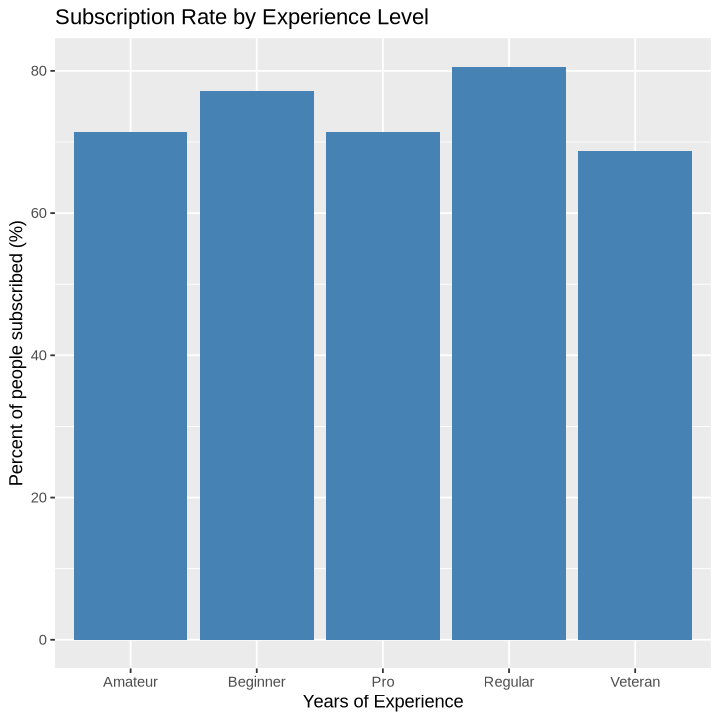

In [45]:
#Some wrangling to be able to make a plot showing the proportion of subscribed players across experience levels
subscription_by_experience <- players_data |>
    group_by(experience) |>
    summarize(subscription_rate = mean(subscribe, na.rm = TRUE)) |>
    mutate(subscription_percent = subscription_rate * 100)

# Bar plot showing the proportion of subscribed players across experience levels
# Helps identify whether more experienced players are more likely to subscribe to the newsletter
options(repr.plot.width = 6, repr.plot.height = 6) 
subscription_rate_plot <- subscription_by_experience |>
    ggplot(aes(x = experience, y = subscription_percent)) +
    geom_bar(stat = "identity", fill = "steelblue") +
    labs(title = "Subscription Rate by Experience Level", x = "Years of Experience", y = "Percent of people subscribed (%)")

subscription_rate_plot

**4. Methods and Plan**

I will predict whether a player subscribes using their demographic information (age, gender, experience) and gameplay behaviour (total play time, number of sessions, average session length).

I’ll use the K-Nearest Neighbors (K-NN) method, which makes predictions based on players with similar characteristics. 

To evaluate performance, I will split the data into a training set to build the model and a test set to measure accuracy. 

I’ll tune the model by trying different values of k and choosing the one with the lowest error on the test set to ensure the best performance.

**5.GitHub Repository**

https://github.com/gavind1111/DSCI-100-Project-Planning-Stage-Gavin